<a href="https://colab.research.google.com/github/sheethalkaran/dqn-atari-pong/blob/main/dqn_pong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Train a DQN to play Atari Pong and analyze reward progression**

In [ ]:
# Install dependencies
!pip install stable-baselines3[extra] gymnasium[atari] autorom -q
!AutoROM --accept-license

In [ ]:
import gymnasium as gym
import ale_py
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import DQN

In [ ]:
# Mount Google Drive to save model
from google.colab import drive
drive.mount("/content/drive")

model_path = "/content/drive/MyDrive/pong_dqn_model"

Mounted at /content/drive


In [ ]:
# Register Atari environments
gym.register_envs(ale_py)

# Create Pong environment
env_id = "PongNoFrameskip-v4"
env = make_atari_env(env_id, n_envs=1, seed=0)
env = VecFrameStack(env, n_stack=4)

In [ ]:
# Callback to store episode rewards
class RewardLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []

    def _on_step(self):
        infos = self.locals.get("infos", None)
        if infos:
            for info in infos:
                if "episode" in info:
                    self.episode_rewards.append(info["episode"]["r"])
        return True

reward_logger = RewardLoggerCallback()

In [ ]:
model = DQN(
    "CnnPolicy",
    env,
    verbose=1,
    buffer_size=50_000,
    learning_starts=10_000,
    batch_size=32,
    gamma=0.99,
    train_freq=4,
    target_update_interval=1_000,
    exploration_fraction=0.3,
    exploration_final_eps=0.01,
    learning_rate=1e-4,
    device="auto"
)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [ ]:
# Train
model.learn(total_timesteps=1_500_000, callback=reward_logger)

In [ ]:
model.save(model_path)
print(f"Model saved to {model_path}.zip")

Model saved to /content/drive/MyDrive/pong_dqn_model.zip


Episodes: 1080
Min reward: -21.0
Max reward: 21.0
Mean reward: -4.09


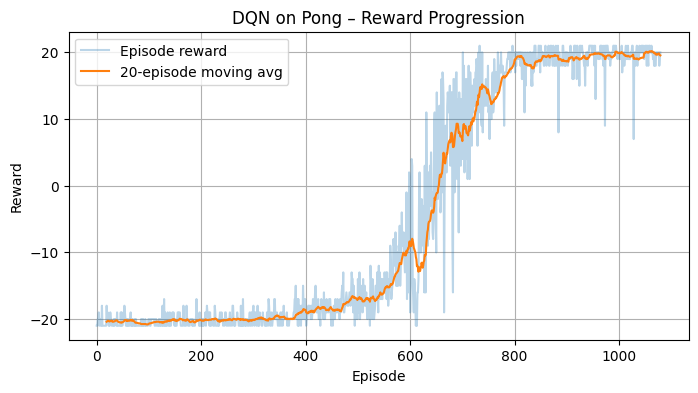

In [ ]:
# Convert rewards
rewards = np.array(reward_logger.episode_rewards)

print("Episodes:", len(rewards))
print("Min reward:", rewards.min())
print("Max reward:", rewards.max())
print("Mean reward:", round(rewards.mean(), 2))

# Plot reward progression
plt.figure(figsize=(8,4))
plt.plot(rewards, alpha=0.3, label="Episode reward")

window = 20
if len(rewards) >= window:
    moving_avg = np.convolve(rewards, np.ones(window)/window, mode="valid")
    plt.plot(range(window - 1, len(rewards)), moving_avg, label="20-episode moving avg")

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN on Pong – Reward Progression")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Evaluation mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

Evaluation mean reward: 20.00 ± 0.00
